# Plot clade connectivity between timepoints

To ensure that clades are connected between timepoints, enabling model fitting across timepoints for all clades, plot the first timepoint each clade occurs in a network and connect adjacent clades with edges based on traversal of the tips-to-clades map for all timepoints.

In [33]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [4]:
valid_tips = tips.strain.unique()

In [5]:
valid_tips.shape

(604,)

In [6]:
data_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/tips_to_clades.tsv"

In [7]:
df = pd.read_csv(data_path, sep="\t", parse_dates=["timepoint"])

In [8]:
df.shape

(39275, 6)

In [9]:
df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Indonesia/1204/2005,e3e25b0,1,h3n2,ha,2009-10-01
1,A/Indonesia/1204/2005,root,2,h3n2,ha,2009-10-01
2,A/Indonesia/2094/2006,e3e25b0,1,h3n2,ha,2009-10-01
3,A/Indonesia/2094/2006,root,2,h3n2,ha,2009-10-01
4,A/Indonesia/1142/2006,e3e25b0,1,h3n2,ha,2009-10-01


In [10]:
df["tip"].isin(valid_tips).sum()

23344

In [11]:
df = df[df["tip"].isin(valid_tips)].copy()

In [12]:
df = tips.merge(df, left_on="strain", right_on="tip", suffixes=["_tip", ""]).copy()

In [13]:
sorted_df = df.sort_values(["timepoint", "tip", "depth"]).copy()

In [14]:
sorted_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Argentina/7646/2009,971938c,2009-10-01,0.006532,A/Argentina/7646/2009,475ef64,1,h3n2,ha,2009-10-01
44,A/Argentina/7646/2009,971938c,2010-04-01,0.000043,A/Argentina/7646/2009,475ef64,1,h3n2,ha,2009-10-01
1,A/Argentina/7646/2009,971938c,2009-10-01,0.006532,A/Argentina/7646/2009,c512845,23,h3n2,ha,2009-10-01
45,A/Argentina/7646/2009,971938c,2010-04-01,0.000043,A/Argentina/7646/2009,c512845,23,h3n2,ha,2009-10-01
2,A/Argentina/7646/2009,971938c,2009-10-01,0.006532,A/Argentina/7646/2009,20ca0a9,37,h3n2,ha,2009-10-01


In [15]:
sorted_df["clade_membership"].unique().shape

(166,)

In [16]:
timepoint_by_clade_name = sorted_df.groupby("clade_membership")["timepoint_tip"].min().to_dict()
timepoint_by_clade_name["root"] = df["timepoint"].min() - pd.DateOffset(months=6)

In [17]:
clade_id_by_name = {"root": 20}
clade_counter_by_timepoint = defaultdict(int)

for clade, timepoint in timepoint_by_clade_name.items():
    clade_id_by_name[clade] = clade_counter_by_timepoint[timepoint]
    clade_counter_by_timepoint[timepoint] += 5

Create a graph that will connect all adjacent clades (essentially the original tree) and note the first timepoint each clade was observed.

In [18]:
tree = nx.Graph()

#timepoint_by_clade_name = {"root": df["timepoint"].min() - pd.DateOffset(months=6)}
observed_tips = set()

for timepoint, timepoint_df in sorted_df.groupby("timepoint"):
    print(timepoint)
    for tip, tip_df in timepoint_df.groupby("tip"):
        # Only consider the clade linkages for tips once when that tip is first observed.
        if tip in observed_tips:
            continue
        
        observed_tips.add(tip)
        clades = tip_df["clade_membership"].values
        
        # Loop through clades, adding edges between adjacent clades.
        for i in range(len(clades)):
            # Make sure each clade is represented in the tree.
            tree.add_node(clades[i])

            # Link each clade after the first one back to its relative.
            if i > 0:
                tree.add_edge(clades[i], clades[i - 1])

            # Note the first timepoint each clade was observed.
            #if clades[i] not in timepoint_by_clade_name:
            #    timepoint_by_clade_name[clades[i]] = tip_timepoint
            #    clade_id_by_name[clades[i]] = clade_counter_by_timepoint[tip_timepoint]
            #    clade_counter_by_timepoint[tip_timepoint] += 5

2009-10-01 00:00:00
2010-04-01 00:00:00
2010-10-01 00:00:00
2011-04-01 00:00:00
2011-10-01 00:00:00
2012-04-01 00:00:00
2012-10-01 00:00:00


In [19]:
tip_df["timepoint_tip"].drop_duplicates().iloc[0]

Timestamp('2012-10-01 00:00:00')

In [20]:
tip

'A/Yokohama/152/2012'

In [21]:
tree["root"]

AtlasView({'779a52a': {}, 'root': {}})

In [22]:
tip_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
36309,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,99a9b94,1,h3n2,ha,2012-10-01
36310,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,2a0ba9c,6,h3n2,ha,2012-10-01
36311,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,37fa5fc,7,h3n2,ha,2012-10-01
36312,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,c380fce,8,h3n2,ha,2012-10-01
36313,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,d4aa5d5,9,h3n2,ha,2012-10-01
36314,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,51dbe77,11,h3n2,ha,2012-10-01
36315,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,73b224d,12,h3n2,ha,2012-10-01
36316,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,23082c4,15,h3n2,ha,2012-10-01
36317,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,475ef64,23,h3n2,ha,2012-10-01
36318,A/Yokohama/152/2012,99a9b94,2012-10-01,0.005361,A/Yokohama/152/2012,c512845,37,h3n2,ha,2012-10-01


In [23]:
tree.number_of_nodes()

148

In [24]:
tree.number_of_edges()

255

In [25]:
positions = {clade: (timepoint_by_clade_name[clade].year + ((timepoint_by_clade_name[clade].month - 1) / 12.0), clade_id_by_name[clade])
             for clade in timepoint_by_clade_name}

In [26]:
list(positions.items())[:10]

[('00448f1', (2011.25, 0)),
 ('013c727', (2009.75, 0)),
 ('02aea16', (2009.75, 5)),
 ('0449848', (2009.75, 10)),
 ('0888771', (2010.25, 0)),
 ('0954cf8', (2010.25, 5)),
 ('0b798f4', (2009.75, 15)),
 ('0bfc046', (2011.75, 0)),
 ('0d1d218', (2011.25, 5)),
 ('124edcb', (2010.25, 10))]

In [38]:
edge_colors = []
for edge in tree.edges:
    delta = timepoint_by_clade_name[edge[1]] - timepoint_by_clade_name[edge[0]]
    if np.abs(delta.days) == 0:
        edge_colors.append("#ffffff")
    elif np.abs(delta.days) < 190:
        edge_colors.append("#cccccc")
    else:
        edge_colors.append("#000000")

In [39]:
valid_timepoints = sorted(set([position[0] for position in positions.values()]))

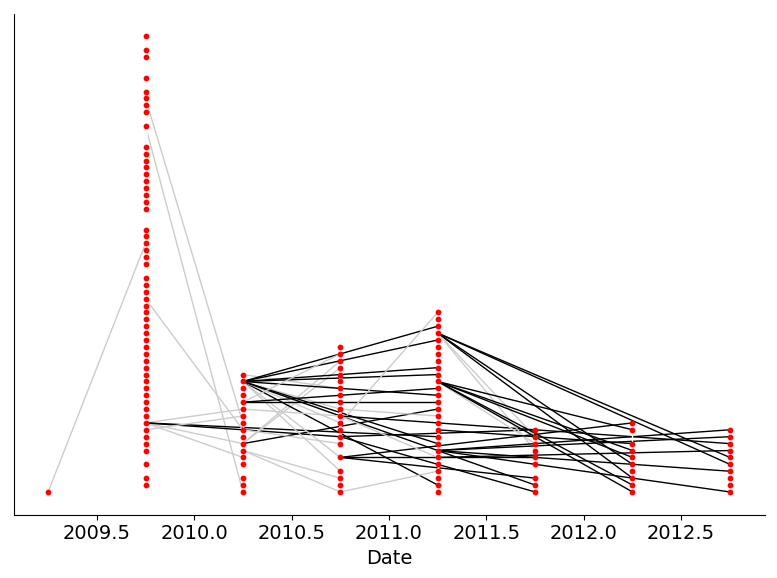

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

nx.draw(
    tree,
    pos=positions,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,
    with_labels=False
)

ax.plot(valid_timepoints, [0.0] * len(valid_timepoints), alpha=0)
ax.set_xlabel("Date")
ax.set_yticks([])
plt.axis("on")
plt.tight_layout()

In [31]:
ax.set_yticks([])

[]

Look for nodes without any edges.

In [32]:
[node for node in tree if len(tree[node]) == 0]

[]

Look for nodes from the last timepoint that connect to nodes from more than one timepoint in the past.

In [33]:
recent_clades = [clade
                 for clade, timepoint in timepoint_by_clade_name.items()
                 if timepoint == df["timepoint"].max()]

In [34]:
recent_clades[:5]

[]

In [35]:
broken_clade = None
for recent_clade in recent_clades:
    for ancestor in tree[recent_clade]:
        delta = timepoint_by_clade_name[recent_clade] - timepoint_by_clade_name[ancestor]
        if delta.days > 190:
            print(delta)
            
        if delta.days > 370:
            print(recent_clade)
            broken_clade = recent_clade
            break
            
    if broken_clade is not None:
        break

In [36]:
recent_clade

NameError: name 'recent_clade' is not defined

In [172]:
broken_clade = "7d7cafb"

In [173]:
df[df["clade_membership"] == broken_clade]

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
8983,A/Antalya/TR-55/2011,cbc56fb,2011-04-01,0.004761,A/Antalya/TR-55/2011,7d7cafb,3,h3n2,ha,2011-10-01
9372,A/Delhi/8865/2011,cbc56fb,2011-04-01,0.184908,A/Delhi/8865/2011,7d7cafb,4,h3n2,ha,2011-10-01
9539,A/Goa/8773/2011,cbc56fb,2011-04-01,0.018457,A/Goa/8773/2011,7d7cafb,4,h3n2,ha,2011-10-01
9722,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,7d7cafb,7,h3n2,ha,2011-10-01
10940,A/Singapore/C2011244/2011,cbc56fb,2011-04-01,0.024127,A/Singapore/C2011244/2011,7d7cafb,7,h3n2,ha,2011-10-01
11223,A/Singapore/GP898/2011,cbc56fb,2011-04-01,0.024174,A/Singapore/GP898/2011,7d7cafb,8,h3n2,ha,2011-10-01
12127,A/Bangladesh/5006/2011,d4aa5d5,2011-10-01,0.034629,A/Bangladesh/5006/2011,7d7cafb,8,h3n2,ha,2011-10-01
12159,A/Bangladesh/5071/2011,d4aa5d5,2011-10-01,0.000009,A/Bangladesh/5071/2011,7d7cafb,6,h3n2,ha,2011-10-01
12281,A/ChiangRai/277/2011,97e8bde,2011-10-01,0.024034,A/ChiangRai/277/2011,7d7cafb,8,h3n2,ha,2011-10-01
12320,A/Georgia/8/2011,d4aa5d5,2011-10-01,0.003936,A/Georgia/8/2011,7d7cafb,13,h3n2,ha,2011-10-01


In [187]:
df[df["tip"] == "A/HongKong/4974/2011"]

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
9711,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,cbc56fb,1,h3n2,ha,2011-04-01
9712,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,73b224d,5,h3n2,ha,2011-04-01
9713,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,23082c4,11,h3n2,ha,2011-04-01
9714,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,475ef64,23,h3n2,ha,2011-04-01
9715,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,9531ae7,54,h3n2,ha,2011-04-01
9716,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,c512845,59,h3n2,ha,2011-04-01
9717,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,18d08a3,60,h3n2,ha,2011-04-01
9718,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,7c85126,61,h3n2,ha,2011-04-01
9719,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,779a52a,65,h3n2,ha,2011-04-01
9720,A/HongKong/4974/2011,cbc56fb,2011-04-01,0.006405,A/HongKong/4974/2011,root,66,h3n2,ha,2011-04-01


In [45]:
tips[tips["strain"] == "A/Okayama/28/2011"]

,strain,clade_membership,timepoint,frequency
284,A/Okayama/28/2011,e4e39db,2011-10-01,0.000003


In [105]:
df[df["clade_membership"] == broken_clade].shape

(80, 6)

In [106]:
bahia_df = df[(df["tip"] == "A/Bahia/100/2011") & (df["timepoint"] == "2012-04-01")]

In [107]:
bahia_df

,tip,clade_membership,depth,lineage,segment,timepoint
25865,A/Bahia/100/2011,e4e39db,1,h3n2,ha,2012-04-01
25866,A/Bahia/100/2011,c3e824d,23,h3n2,ha,2012-04-01
25867,A/Bahia/100/2011,23082c4,25,h3n2,ha,2012-04-01
25868,A/Bahia/100/2011,475ef64,27,h3n2,ha,2012-04-01
25869,A/Bahia/100/2011,c512845,53,h3n2,ha,2012-04-01
25870,A/Bahia/100/2011,18d08a3,67,h3n2,ha,2012-04-01
25871,A/Bahia/100/2011,4f7d9e7,69,h3n2,ha,2012-04-01
25872,A/Bahia/100/2011,779a52a,70,h3n2,ha,2012-04-01
25873,A/Bahia/100/2011,root,72,h3n2,ha,2012-04-01


In [108]:
parana_df = df[(df["tip"] == "A/Parana/415/2012") & (df["timepoint"] == "2012-10-01")]

In [109]:
parana_df

,tip,clade_membership,depth,lineage,segment,timepoint
32145,A/Parana/415/2012,93a23e6,1,h3n2,ha,2012-10-01
32146,A/Parana/415/2012,e4e39db,6,h3n2,ha,2012-10-01
32147,A/Parana/415/2012,c3e824d,8,h3n2,ha,2012-10-01
32148,A/Parana/415/2012,23082c4,10,h3n2,ha,2012-10-01
32149,A/Parana/415/2012,475ef64,12,h3n2,ha,2012-10-01
32150,A/Parana/415/2012,c512845,26,h3n2,ha,2012-10-01
32151,A/Parana/415/2012,20ca0a9,41,h3n2,ha,2012-10-01
32152,A/Parana/415/2012,7c85126,42,h3n2,ha,2012-10-01
32153,A/Parana/415/2012,779a52a,44,h3n2,ha,2012-10-01
32154,A/Parana/415/2012,root,46,h3n2,ha,2012-10-01


In [110]:
tips[tips["strain"] == "A/Bahia/100/2011"]

,strain,clade_membership,timepoint,frequency
180,A/Bahia/100/2011,e4e39db,2011-04-01,0.022784


In [111]:
tips[tips["strain"] == "A/HoChiMinh/6388/2010"]

,strain,clade_membership,timepoint,frequency


In [112]:
# Identify distinct clades per timepoint.
clades = tips.loc[:, ["timepoint", "clade_membership"]].drop_duplicates().copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})

In [113]:
clades[clades["clade_membership"] == "93a23e6"]

,initial_timepoint,clade_membership
393,2012-10-01,93a23e6


In [114]:
df[df["clade_membership"] == "93a23e6"]

,tip,clade_membership,depth,lineage,segment,timepoint
32025,A/Okayama/28/2011,93a23e6,1,h3n2,ha,2012-10-01
32075,A/Nicaragua/AGA2-03/2012,93a23e6,1,h3n2,ha,2012-10-01
32085,A/Nicaragua/AGA2-72/2012,93a23e6,1,h3n2,ha,2012-10-01
32105,A/SantiagoDelEstero/1061/2012,93a23e6,1,h3n2,ha,2012-10-01
32115,A/Bahia/100/2011,93a23e6,1,h3n2,ha,2012-10-01
32125,A/Norway/1443/2012,93a23e6,1,h3n2,ha,2012-10-01
32135,A/RioDeJaneiro/763/2012,93a23e6,1,h3n2,ha,2012-10-01
32145,A/Parana/415/2012,93a23e6,1,h3n2,ha,2012-10-01
32155,A/BuenosAires/2508/2012,93a23e6,1,h3n2,ha,2012-10-01
32166,A/Tucuman/I2042/2012,93a23e6,2,h3n2,ha,2012-10-01


In [115]:
clades[clades["initial_timepoint"] == "2012-04-01"]

,initial_timepoint,clade_membership
312,2012-04-01,d4aa5d5
313,2012-04-01,361f8b8
315,2012-04-01,97e8bde
318,2012-04-01,99a9b94
320,2012-04-01,3f5a5d3
334,2012-04-01,5f0cf16
342,2012-04-01,37fa5fc
354,2012-04-01,e4e39db


In [116]:
clades[clades["initial_timepoint"] == "2012-10-01"]

,initial_timepoint,clade_membership
387,2012-10-01,361f8b8
388,2012-10-01,d4aa5d5
391,2012-10-01,2a0ba9c
392,2012-10-01,3f5a5d3
393,2012-10-01,93a23e6
403,2012-10-01,99a9b94
406,2012-10-01,5f0cf16
415,2012-10-01,37fa5fc
444,2012-10-01,e4e39db
447,2012-10-01,97e8bde


In [188]:
final_clade_frequencies = pd.read_table("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/final_clade_frequencies.tsv")

In [190]:
final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum()

initial_timepoint  clade_membership
2009-10-01         23082c4             0.538243
                   475ef64             0.070054
                   4b9bac7             0.000000
                   b1f1517             0.390870
                   c205092             0.000000
                   d6f8d49             0.000058
2010-04-01         23082c4             0.447790
                   475ef64             0.000000
                   4f8ce01             0.011113
                   73b224d             0.452016
                   9485944             0.078828
                   b1f1517             0.010256
                   c512845             0.000000
                   d6f8d49             0.000000
2010-10-01         23082c4             0.173099
                   4f8ce01             0.000000
                   57327fc             0.139239
                   5d0b2f4             0.006090
                   73b224d             0.263197
                   b1f1517             0.000000
    

In [191]:
clade_counts = final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum().reset_index()

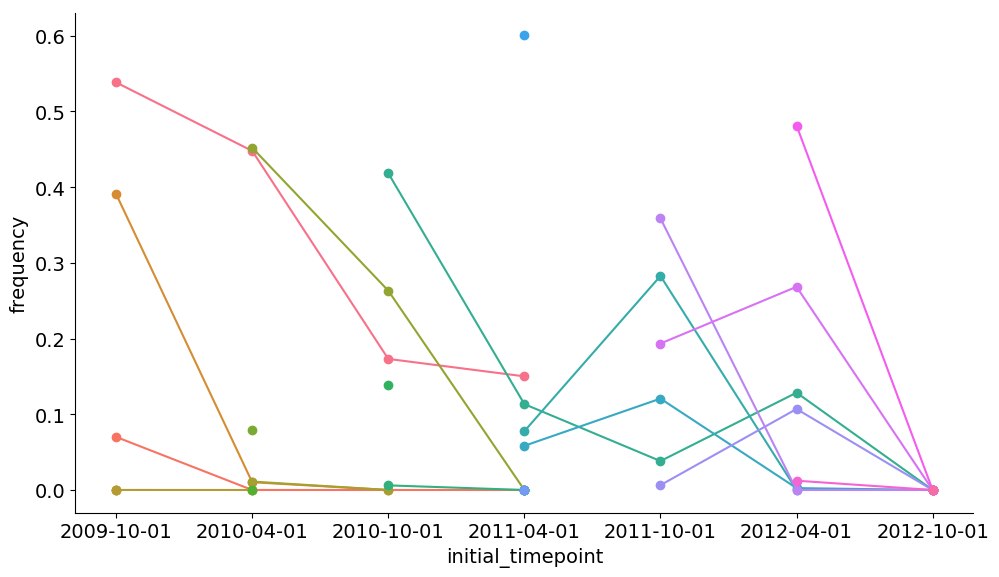

In [194]:
g = sns.FacetGrid(clade_counts, hue="clade_membership", height=6, aspect=1.7)
g.map(plt.plot, "initial_timepoint", "frequency", marker="o")
#g.axes.flatten()[0].set_ylim(0, 1)